##### TODO

- simulate buying stocks (buy/sell decisions)
- ~~adjust LSTM~~
- ~~add regulation (L2 regularization/validation)~~
- try: shorter LSTM sequence
- investigate: why are all of the outputs nearly the same?

In [1]:
import yfinance as yf
import pandas as pd
from matplotlib import pyplot as plt

from tensorflow import keras
import numpy as np
import datetime

In [2]:
def sampleDataset(price_changes, num_samples, interval_len, extension):
    # creates samples of data from a dataset
    # returns the intervals, and the target price changes

    price_intervals = np.ndarray((num_samples, interval_len))
    target_changes = np.ndarray((num_samples, extension))
    # print(num_samples)
    # print(len(price_changes))
    # print(interval_len)
    # print(extension)
    for x in range(num_samples):
        # print(x)
        start_index = np.random.randint(len(price_changes) - interval_len - extension)
        # start_index = round(x * ((len(price_changes) - interval_len - extension)) / num_samples)


        price_intervals[x] = price_changes[start_index:start_index + interval_len]

        # if x == 0:
        #     print(price_intervals[x])

        # print(price_intervals[x])
        target_changes[x] = price_changes[start_index + interval_len:start_index + interval_len + extension]
        # print(target_changes[x])
        # print()
    
    return price_intervals, target_changes

In [3]:
# Calculate hourly price changes for the ticker.
import pickle

df = pd.read_csv("a.csv")

# TICKER = list(df.loc[:, "Symbol"])[:20]
# TICKER = ["MSFT", "AAPL", "NVDA", "MMM", "ABBV", "ADBE", "GOOGL", "T", "CMCSA", "DIS", "EA", "FOX", "META", "NFLX", "WBD", "ABNB", "TSLA", "AMZN", "DBX"]
TICKER = ["MSFT", "AAPL", "NVDA"]

# print(TICKER[96])

DATASET_SIZE = 20000 # Number of samples PER TICKER
INTERVAL = 7 * 28
EXTENSION = 1

# fetch hists
try:
    with open("hists.dat", "rb") as f:
        hists = pickle.load(f) 
except:
    hists = []
    for x in range(len(TICKER)):
        print("LOADING TICKER " + str(x + 1) + "/" + str(len(TICKER)), end="\r")
        hist = yf.Ticker(TICKER[x]).history(interval="1h", period="2y")
        if not hist.empty and np.sum(np.isnan(hist.loc[:, "Open"].to_numpy())) == 0:
            hists.append(hist)


price_intervals = np.ndarray((len(hists), DATASET_SIZE, 1, INTERVAL))
target_changes = np.ndarray((len(hists), DATASET_SIZE, EXTENSION))
for x in range(len(hists)):
    # print(hists[x].loc[:, "Open"].to_numpy().shape)
    open_prices = hists[x].loc[:, "Open"].to_numpy()[:-1]
    # next_prices = hists[x].loc[:, "Open"].to_numpy()[1:]
    # print(open_prices.shape)
    
    open_prices = hists[x].loc[:, "Open"].to_numpy()
    next_prices = hists[x].loc[:, "Close"].to_numpy()

    ''' top: $ change, centered at 0
        bottom: net change'''
    
    # price_changes = (next_prices - open_prices) / open_prices * 100
    price_changes = next_prices - open_prices
    # print(price_changes.shape)
    
    '''==='''

    # print(open_prices.shape)
    # print(next_prices.shape)
    # print(open_prices[:5])
    # print(next_prices[:5])
    # print(price_changes[:5])
    
    intervals, target_changes[x] = sampleDataset(price_changes, DATASET_SIZE, INTERVAL, EXTENSION)
    if x == 0:
        # print(intervals[0])
        print(price_changes[:9])
    # print(intervals.shape)
    # print(intervals[0])
    price_intervals[x] = np.expand_dims(intervals, axis=1)
    # print("=====")
    # print(price_intervals[x].shape)
    # print(price_intervals[x][0])
    # intervals.reshape(intervals.shape[0], 1, intervals.shape[1])
    # print(price_intervals[x, 0, 0, :5])

    if(np.sum(np.isnan(price_intervals[x]))):
        print("NAN: " + str(x))
        print(np.where(np.isnan(price_intervals[x])))
        # print(intervals[0])
        # print(open_prices)
        print(price_intervals[x][0][0])
        display(hists[x])

# print(price_intervals)

# print(price_intervals[0, :5])
# print(price_intervals.shape)
price_intervals = price_intervals.reshape((len(hists) * DATASET_SIZE, 1, INTERVAL))
# print(price_intervals[:5])
# print(price_intervals.shape)
target_changes = target_changes.reshape((len(hists) * DATASET_SIZE, EXTENSION))

with open("hists.dat", "wb") as f:
    pickle.dump(hists, f)

def normalize(data):
    return (data - np.mean(data)) / np.std(data)

# price_intervals = normalize(price_intervals)
# target_changes = normalize(target_changes)

np.set_printoptions(suppress=True)
# print()
print(price_intervals.shape)
# print(target_changes.shape)
# print(price_intervals[0, :, 0])
# print(target_changes[0])
# plt.hist(price_intervals[:, :, 0])
# plt.show()

# print("===")
N = 0
# print(hists[0].loc[:, "Open"][:5])
print(hists[0].loc[:, "Open"][:9])
# initial = hists[0].loc[:, "Open"].to_numpy()[0]
# print(price_intervals[0, 0, :5])
# print(np.cumsum(price_intervals[0, 0, :5]) + initial)
# for e in target_changes:
    # print(e, end="   ")
# print(price_intervals)


[ 0.70001221 -4.63497925  1.19000244  2.85998535 -1.53997803  1.05999756
  0.3999939  -0.69998169  0.30499268]
(60000, 1, 196)
Datetime
2021-11-26 09:30:00-05:00    334.829987
2021-11-26 10:30:00-05:00    335.489990
2021-11-26 11:30:00-05:00    330.880005
2021-11-29 09:30:00-05:00    334.940002
2021-11-29 10:30:00-05:00    337.829987
2021-11-29 11:30:00-05:00    336.269989
2021-11-29 12:30:00-05:00    337.350006
2021-11-29 13:30:00-05:00    337.739990
2021-11-29 14:30:00-05:00    337.024994
Name: Open, dtype: float64


In [11]:
# Create LSTM model
LEARNING_RATE = 0.001
REG_FACTOR = 0 
VAL_RATIO = 0

# Define the LSTM model
model = keras.Sequential()
# model.add(keras.layers.Input((1, INTERVAL)))
model.add(keras.layers.LSTM(units=64, input_shape=(1, INTERVAL)))
# model.add(keras.layers.Dense(units=64, activation="relu", kernel_regularizer=keras.regularizers.l2(REG_FACTOR)))
# model.add(keras.layers.Dense(units=EXTENSION, activation="linear", kernel_regularizer=keras.regularizers.l2(REG_FACTOR)))
# model.add(keras.layers.LSTM(units=32, input_shape=(INTERVAL, 1), return_sequences=True))
# model.add(keras.layers.Dropout(0.1))
# model.add(keras.layers.LSTM(units=32, input_shape=(INTERVAL, 1)))
# model.add(keras.layers.Dropout(0.1))
# model.add(keras.layers.Flatten())
# model.add(keras.layers.Dense(units=64, activation="relu"))
model.add(keras.layers.Dense(units=EXTENSION, activation="linear"))

# Compile the model
model.compile(loss=keras.losses.MSE, optimizer=keras.optimizers.Adam(learning_rate=LEARNING_RATE))

# model.build((None, 1, INTERVAL))
# model.summary()

In [12]:
num_epochs = 10
batch_size = 256

# print(model.predict(np.expand_dims(price_intervals[0], axis=0)))
# Train the model
model.fit(price_intervals, target_changes, epochs=num_epochs, batch_size=batch_size)

# print(model.predict(np.expand_dims(price_intervals[0], axis=0)))

# Evaluate the model
# print(price_intervals.shape)
# print(target_changes.shape)
metrics = model.evaluate(price_intervals, target_changes)

# Make predictions
N = 1
for x in range(len(price_intervals))[:5]:
    predictions = model.predict(np.expand_dims(price_intervals[x], axis=0))
    print("PREDICTION: " + str(predictions[0,0]))   
    print("ACTUAL: " + str(target_changes[x,0]))
    print("ERROR (%): " + str((predictions[0,0] - target_changes[x,0]) / target_changes[x,0] * 100))
    # print("ERROR (MSE): " + str((predictions[0,0] - target_changes[0,0]) ** 2))
    print("========")

# print(price_intervals[:10])
# predictions = model.predict(price_intervals[:10])[:, 0]
# print(predictions)

Epoch 1/10
235/235 [==============================] - 3s 6ms/step - loss: 2.6162
Epoch 2/10
235/235 [==============================] - 1s 6ms/step - loss: 0.9448
Epoch 3/10
235/235 [==============================] - 1s 5ms/step - loss: 0.3224
Epoch 4/10
235/235 [==============================] - 1s 5ms/step - loss: 0.1427
Epoch 5/10
235/235 [==============================] - 1s 5ms/step - loss: 0.0773
Epoch 6/10
235/235 [==============================] - 1s 5ms/step - loss: 0.0476
Epoch 7/10
235/235 [==============================] - 1s 5ms/step - loss: 0.0344
Epoch 8/10
235/235 [==============================] - 1s 5ms/step - loss: 0.0259
Epoch 9/10
235/235 [==============================] - 1s 6ms/step - loss: 0.0222
Epoch 10/10
1/1 [==============================] - 0s 293ms/step
PREDICTION: -2.1427634
ACTUAL: -2.10400390625
ERROR (%): 1.8421767122592247
1/1 [==============================] - 0s 18ms/step
PREDICTION: 1.6594213
ACTUAL: 1.75
ERROR (%): -5.175924301147461
1/1 [========

In [6]:
from numpy import NaN


def get_samples(hists, interval, type="change", offset=0, steps=0):
    num_hists = len(hists)
    samples = np.ndarray((num_hists, interval + steps))
    timestamps = np.ndarray((num_hists, 2), dtype="datetime64[s]")
    for x in range(num_hists):
        hist = hists[x]

        hist_times = np.asarray(hist.index.astype(np.int64) / (10 ** 9), dtype="datetime64[s]")
        timestamps[x] = np.array((hist_times[-interval - offset], hist_times[-1 - offset + steps]))

        open_prices = hists[x].loc[:, "Open"].to_numpy()[:-1]
        next_prices = hists[x].loc[:, "Open"].to_numpy()[1:]

        price_changes = (next_prices - open_prices) / open_prices * 100

        if type == "change":
            samples[x] = price_changes[-interval - offset:price_changes.shape[0] - offset + steps]
        elif type == "open":
            samples[x] = open_prices[-interval - offset:price_changes.shape[0] - offset + steps]

    return samples, timestamps

def format_datetime(timestamp):
    return timestamp.astype(datetime.datetime).strftime("%m/%d/%Y, %H:%M")

def plot(ticker, sample, timestamps, predictions=np.array((NaN,)), actual=np.array((NaN,)), actual_end=None, type="change", offset=0, change_error=False):
    print("=== " + ticker + ": " + type + " ===")
    print("Start: " + format_datetime(timestamps[0]))
    print("  End: " + format_datetime(timestamps[1]))
    
    sample = sample[offset:]
    actual = actual[offset:]

    fig = plt.figure(figsize=(12, 3))
    ax_sample = fig.add_subplot(141)
    ax_sample.plot(sample)
    ax_sample.set_title("Sample")

    if predictions[0] != NaN:
        # print(sample[-1])
        # print(sample)
        # print(predictions)
        # print(np.cumsum(predictions))

        
        if type != "change":
            # predictions = sample[-1] * np.cumprod(predictions / 100 + 1)
            predictions = np.cumsum(predictions) + sample[-1]
            # predictions = predictions + sample[-1]
            


        # print(predictions)


        forecast = np.concatenate((sample, predictions))
        ax_prediction = fig.add_subplot(142)
        ax_prediction.plot(forecast)
        ax_prediction.set_title("Prediction")
    else:
        print("plot(): predictions either NaN or not given")
        
    if actual[0] != NaN:
        print("Actual prices end: " + format_datetime(actual_end))
        ax_actual = fig.add_subplot(143)
        ax_actual.plot(actual)
        ax_actual.set_title("Actual")
    else:
        print("plot(): actual values either NaN or not given")

    if change_error:
        ax_error = fig.add_subplot(144)
        forecast = np.concatenate((sample, predictions))
        ax_error.plot(forecast - actual)
        ax_error.set_title("Error in prediction")

    plt.show()

def predict(model, samples, steps):
    '''FOR CHAINED PREDICTIONS'''
    predictions = np.ndarray((samples.shape[0], steps))

    # print(predictions.shape)
    # print(samples.shape)
    # print(np.expand_dims(samples, axis=1).shape)
    for x in range(steps):
        # print(model.predict(np.expand_dims(samples, axis=2), verbose=0).shape)
        predictions[:, x] = model.predict(np.expand_dims(samples, axis=1), verbose=0)[:, 0]

        samples[:, :INTERVAL - 1] = samples[:, 1:]
        samples[:, INTERVAL - 1] = predictions[:, x]
    return predictions

=== MSFT: change ===
Start: 10/13/2023, 17:30
  End: 11/22/2023, 17:30
Actual prices end: 11/24/2023, 17:30


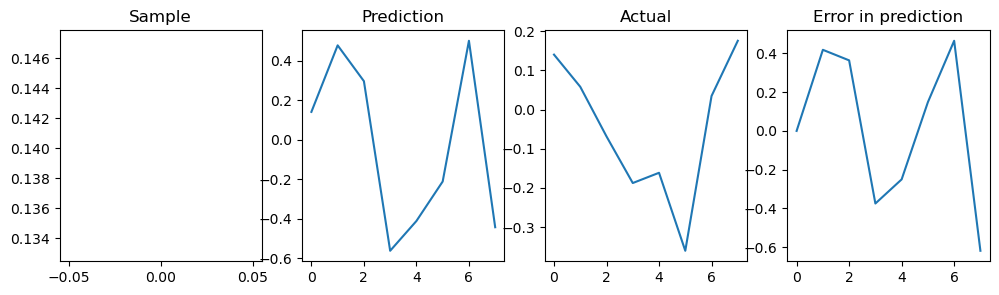

=== AAPL: change ===
Start: 10/13/2023, 17:30
  End: 11/22/2023, 17:30
Actual prices end: 11/24/2023, 17:30


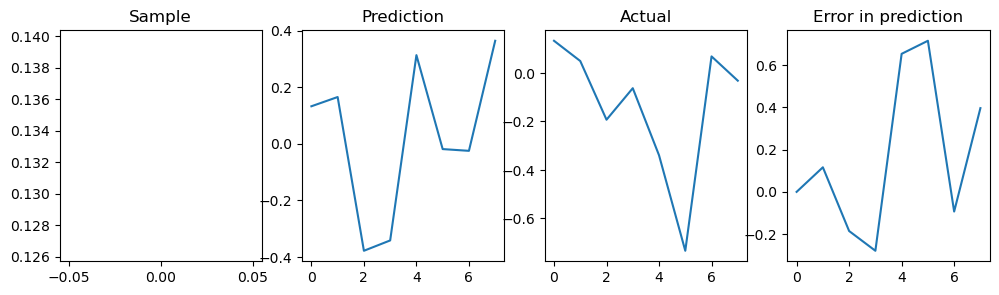

=== NVDA: change ===
Start: 10/13/2023, 17:30
  End: 11/22/2023, 17:30
Actual prices end: 11/24/2023, 17:30


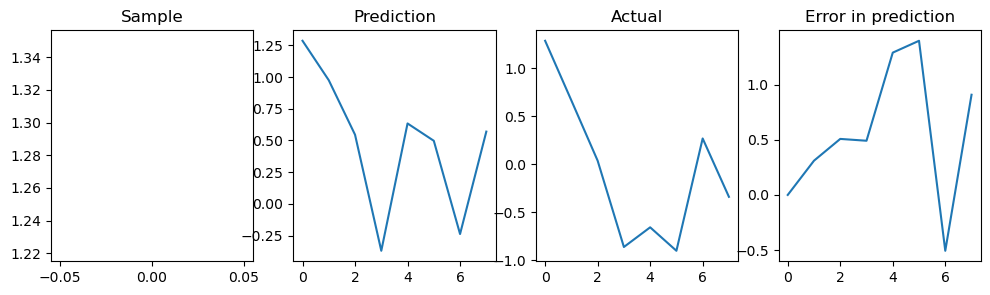

In [13]:
STEPS = 7
BACK_OFFSET = 1
TYPE = "change"

input_sample, _ = get_samples(hists, INTERVAL, type="change", offset=STEPS)
samples, timestamps = get_samples(hists, INTERVAL, type=TYPE, offset=STEPS)
actuals, actuals_end = get_samples(hists, INTERVAL, type=TYPE, offset=STEPS, steps=STEPS)

# print(samples.shape)
# print(actuals.shape)

predictions = predict(model, np.copy(input_sample), STEPS)

# print(samples.shape)
# print(timestamps.shape)
# print(actuals.shape)
# print(actuals_end.shape)
# print(predictions.shape)
# print(predictions)
# print(predictions[0:2])

act_change, _ = get_samples(hists, INTERVAL, type="change", offset=STEPS, steps=STEPS)


for x in range(len(hists)):
    plot(TICKER[x], samples[x], timestamps[x], predictions=predictions[x], actual=actuals[x], actual_end=actuals_end[x][1], type=TYPE, offset=INTERVAL - BACK_OFFSET, change_error=True)
    # pred = predictions[x, :5]
    # acts = actuals[x, -STEPS:-STEPS + 5]
    # act_change = act_change[x, -STEPS:-STEPS + 5]

    


In [ ]:
# INDEX = 0

# # index = np.random.randint()
# sample = (hists[INDEX].loc[:, "Close"] - hists[INDEX].loc[:, "Open"])[:INTERVAL]
# sample = np.expand_dims(np.expand_dims(sample, axis=0), axis=0)

# original = (hists[INDEX].loc[:, "Close"] - hists[INDEX].loc[:, "Open"])[:INTERVAL].to_numpy()
# actual = (hists[INDEX].loc[:, "Close"] - hists[INDEX].loc[:, "Open"])[:INTERVAL + EXTENSION].to_numpy()
# # print(sample.shape)
# # print(sample)
# predictions = predict(model, sample)
# extended = np.concatenate((original, predictions))

# print("Original plot")
# plt.plot(original, color="blue")
# plt.show()

# print("Extrapolated plot")
# plt.plot(predictions, color="blue")
# plt.show()

# print("Actual plot")
# plt.plot(actual[INTERVAL:], color="blue")
# plt.show()

# print("Difference (pred - real) plot")
# plt.plot(predictions - actual[INTERVAL:], color="blue")
# plt.show()